In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


In [2]:
data_file = 'arrhythmia.data'
df = pd.read_csv(data_file, header=None)


In [41]:
## replicating data points with 5 or fewer samples  
from collections import Counter
class_counts = Counter(df.iloc[:,-1])   # counting class labels 
classes_to_augment = [class_label for class_label, count,  in class_counts.items() if count<6] # identify class labels to replicate 
# loop over classes to replicate
for class_label in classes_to_augment:
    class_rows = df[df.iloc[:,-1]==class_label]
     # replicate the rows until the class count reaches at least 6
    while class_counts[class_label]<6:
        df = pd.concat([df, class_rows], ignore_index=True)
        class_counts[class_label] += len(class_rows)
class_counts = Counter(df.iloc[:,-1])
for class_label, count in class_counts.items():
    print(f" Class {class_label} has {count}")

 Class 8 has 6
 Class 6 has 25
 Class 10 has 50
 Class 1 has 245
 Class 7 has 6
 Class 14 has 8
 Class 3 has 15
 Class 16 has 22
 Class 2 has 44
 Class 4 has 15
 Class 5 has 13
 Class 9 has 9
 Class 15 has 10


In [42]:
# handling missing values 
from sklearn.impute import SimpleImputer
df.replace("?", np.nan, inplace=True)
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputed_data = imputer.fit_transform(df)
df_imputed = pd.DataFrame(imputed_data, columns=df.columns)
print(df_imputed.shape)

(468, 280)


In [5]:
X = df_imputed.iloc[ :,:-1].values
y=df_imputed.iloc[:,-1]
print(np.shape(X))
print(np.shape(y))

(468, 279)
(468,)


In [19]:
# from imblearn.over_sampling import SMOTE
# X_res, y_res = SMOTE(random_state=0).fit_resample(X, y)
# print(X_res.shape)
# print(y_res.shape)

# SMOTE makes ANN worse 

(3185, 279)
(3185,)


In [56]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

sc = StandardScaler()

# features scaling 
X_scaled = sc.fit_transform(X)
pca = PCA()
pca.fit(X_scaled)
pca_data = pca.transform(X_scaled)

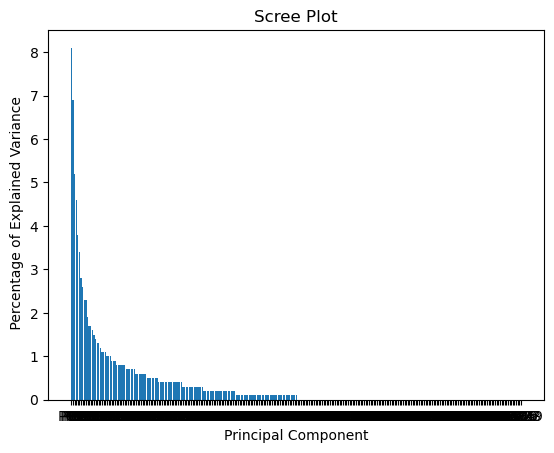

In [57]:
# compute the percentage of explained variance for each principal component
per_var = np.round(pca.explained_variance_ratio_*100, decimals=1)

# create labels for the principal components 
labels = ['PC' + str(i) for i in range(1, len(per_var) + 1)]

# plotting 
plt.bar(x=range(1,len(per_var) + 1), height=per_var, tick_label=labels)
plt.xlabel('Principal Component')
plt.ylabel(' Percentage of Explained Variance')
plt.title('Scree Plot')
plt.show()

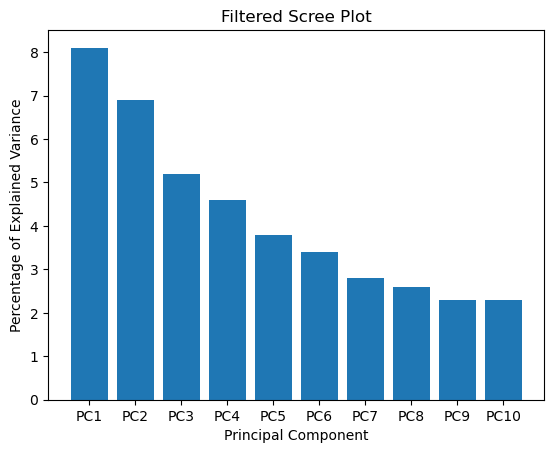

In [63]:
threshold = 2  # 2% for ANN to reduce dimensionality more 
important_components = per_var[per_var >= threshold]


plt.bar(x=range(1, len(important_components) + 1), height=important_components, tick_label=labels[:len(important_components)])
plt.xlabel('Principal Component')
plt.ylabel('Percentage of Explained Variance')
plt.title('Filtered Scree Plot')
plt.show()

In [64]:
important_indices = [i for i, variance in enumerate(per_var) if variance >= threshold]
important_pca_data = pca_data[:, important_indices]
print(important_pca_data.shape)

(468, 10)


In [65]:
new_X = pd.DataFrame(important_pca_data)
print(X.shape)
print(y.shape)

(468, 279)
(468,)


In [66]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(new_X, y, test_size=0.2, random_state=0)
print(X_train.shape)


(374, 10)


In [74]:
import tensorflow as tf

ann = tf.keras.models.Sequential()

# adding the input layer
ann.add(tf.keras.layers.Dense(units=100, activation='relu'))
ann.add(tf.keras.layers.Dense(units=100, activation='relu'))
ann.add(tf.keras.layers.Dense(units=100, activation='relu'))
# adding output layer
ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

# compiling the ANN
ann.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

ann.fit(X_train, y_train, batch_size=32, epochs=20)



Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.2623 - loss: 0.9348    
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5473 - loss: -12.8801
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5722 - loss: -38.2010 
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5962 - loss: -124.2136 
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5942 - loss: -285.7177 
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5584 - loss: -652.8484 
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5371 - loss: -1225.8834 
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5296 - loss: -2578.6392 
Epoch 9/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5602 - loss: -4725.6665 
Epoch 10/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5611 - loss: -6829.5322 
Epoch 11/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step - accuracy: 0.5640 - loss: -9953.1035
Epoch 12/20
12/12 ━━━━━━━━━